In [143]:
#%%
# Section of the Python code where we import all dependencies on third party Python modules/libaries or our own
# libraries (exposed C++ code to Python, i.e. darts.engines && darts.physics)
from model_deadoil import ModelDA
import numpy as np
import meshio
from darts.engines import *

import concurrent.futures
import math
import os
import re
import shutil
import time

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [156]:
#%%
#First we define the model that will be used as refference frac_aper = = 1e-3 (base case produced by Stephan)
# 
m_true = ModelDA(frac_aper =0.001)

# After constructing the model, the simulator needs to be initialized. The init() class method is called, which is
# inherited (https://www.python-course.eu/python3_inheritance.php) from the parent class DartsModel (found in
# darts/models/darts_model.py (NOTE: This is not the same as the__init__(self, **) method which each class (should)
# have).
m_true.init()
# Specify some other time-related properties (NOTE: all time parameters are in [days])
m_true.params.max_ts = 20  # Adjust the maximum time-step as desired (this is overwriting the max_ts specified in model.py)
m_true.run(1000)

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8



In [157]:
import pandas as pd
time_data = pd.DataFrame.from_dict(m_true.physics.engine.time_data)
writer = pd.ExcelWriter('m_true_time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()



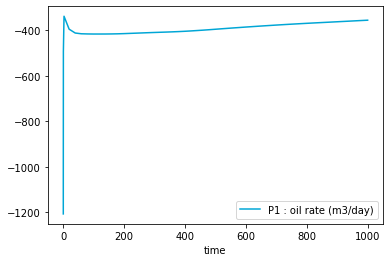

In [158]:
from darts.tools.plot_darts import *
prod = m_true.reservoir.wells[1]
inj =   m_true.reservoir.wells[0]
ax2 = plot_oil_rate_darts(prod.name, time_data)


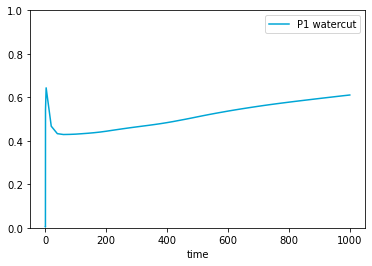

In [159]:
ax3 = plot_watercut_darts(prod.name, time_data)

In [160]:
##Create hard data from true model
obsData= -1*np.array(time_data['P1 : oil rate (m3/day)'])
obsValues = np.array(obsData)
dObs = obsValues.T.flatten()
dTime= np.array(time_data['time']).ravel(order='F')

CeDiag =np.array(0.001*dObs[:]) #diagonal of the covariance matrix of observed data %1 of the oil rate
NTimesteps=len(dTime)
NWells=1
wells = ['P1']
wellDObs = np.repeat(wells, NTimesteps) #Configure the wells list


In [161]:
#create a function to run ensemble simulations based on the prior ensemble
def RunModels(destDir, MScalar):
    for i, mMScalar in enumerate(MScalar.T):
        # create a model object
        m = ModelDA(frac_aper = mMScalar);
        # initialize the model
        m.init();
        # run the model
        start = time.time()
        m.run(1000);
        # get the data
        time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
         # write timedata to output file
        time_data.to_pickle(f'{destDir}\\data_model'+str(i)+'.pkl')  
        end = time.time()
        print(f'Elapsed time: {end - start} for model {str(i)}')

In [162]:
#Read the result from the model
def ReadModels(destDir, columnsNameList, Nd, Ne):
    D = np.empty([Nd, Ne])
    for i in range(Ne):
        dataSet = pd.read_pickle(f'{destDir}\\data_model'+str(i)+'.pkl') 
        model_value=np.array([])
        for name in columnsNameList:
            model_value = np.append(model_value,-1*dataSet[name][:])
        
        d_models = model_value.T.flatten()    
           
        D[:,i] = d_models 

    return D

In [137]:
#Read the result from the model

D = np.empty([Nd, Ne])
for i in range(Ne):
    dataSet = pd.read_pickle(f'{destDir}\\data_model'+str(i)+'.pkl') 
    model_value=np.array([])
    for name in columnsNameList:
        model_value = np.append(model_value,-1*dataSet[name][:])
    
    d_models = model_value.T.flatten()    
        
    D[:,i] = d_models 

D

ValueError: could not broadcast input array from shape (110,) into shape (109,)

In [155]:
pd.DataFrame([dataSet['time'],time_data['time']]) 


,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
time,0.000001,0.000009,0.000073,0.000585,0.004681,0.037449,0.299593,0.561737,2.658889,19.436105,...,1839.436105,1859.436105,1879.436105,1899.436105,1919.436105,1939.436105,1959.436105,1979.436105,1999.436105,2000.0
time,0.000001,0.000009,0.000073,0.000585,0.004681,0.037449,0.299593,2.396745,19.173961,39.173961,...,1859.173961,1879.173961,1899.173961,1919.173961,1939.173961,1959.173961,1979.173961,1999.173961,2000.000000,NaN


In [141]:
dataSet


,I1 : p 0 c 1 rate (Kmol/day),I1 : c 1 rate (Kmol/day),time,I1 : water rate (m3/day),I1 : p 0 reservoir P (bar),I1 : oil rate (m3/day),I1 : liquid rate (m3/day),I1 : p 0 c 0 rate (Kmol/day),I1 : c 0 rate (Kmol/day),I1 : BHP (bar),...,P1 : oil rate (m3/day),P1 : p 0 c 0 rate (Kmol/day),P1 : c 0 rate (Kmol/day),P1 : liquid rate (m3/day),P1 : p 0 c 1 rate (Kmol/day),P1 : c 1 rate (Kmol/day),P1 : p 0 reservoir P (bar),P1 : BHP (bar),FIPS c 0 (kmol),FIPS c 1 (kmol)
0,3.105063e-15,3.103311e-15,0.000001,3726.034816,370.177004,0.0,3726.034816,3.822012e+06,3.819856e+06,375.0,...,-1348.176801,-4881.461958,-4985.520225,-1353.039869,-1.149003e+06,-1.144574e+06,342.971532,325.0,2.376037e+09,7.704461e+09
1,3.561219e-15,3.561186e-15,0.000009,4275.789367,369.468462,0.0,4275.789367,4.383493e+06,4.383454e+06,375.0,...,-1346.785097,-4855.585046,-4980.245539,-1351.643020,-1.143493e+06,-1.143392e+06,342.885460,325.0,2.376037e+09,7.704461e+09
2,4.530747e-15,4.530736e-15,0.000073,5439.894122,367.962523,0.0,5439.894122,5.576881e+06,5.576871e+06,375.0,...,-1345.559413,-4832.914407,-4974.544970,-1350.411775,-1.142467e+06,-1.142352e+06,342.868972,325.0,2.376037e+09,7.704461e+09
3,7.178320e-15,7.178312e-15,0.000585,8618.744257,363.850124,0.0,8618.744257,8.835767e+06,8.835764e+06,375.0,...,-1336.642759,-4769.663508,-4930.997316,-1341.452644,-1.134913e+06,-1.134782e+06,342.750098,325.0,2.376041e+09,7.704461e+09
4,8.813811e-15,8.813802e-15,0.004681,10582.419049,361.309762,0.0,10582.419049,1.084888e+07,1.084888e+07,375.0,...,-1289.920214,-4594.504857,-4703.490520,-1294.508179,-1.095204e+06,-1.095115e+06,342.128990,325.0,2.376086e+09,7.704456e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,1.051197e-15,1.051197e-15,1939.436105,1262.134811,373.367207,0.0,1262.134811,1.293915e+06,1.293915e+06,375.0,...,-318.039813,-961595.442153,-961595.356598,-1256.016906,-2.700091e+05,-2.700091e+05,334.820925,325.0,3.145920e+09,7.083509e+09
106,1.054102e-15,1.054102e-15,1959.436105,1265.622291,373.362695,0.0,1265.622291,1.297491e+06,1.297491e+06,375.0,...,-316.918055,-966382.575060,-966382.479675,-1259.564692,-2.690567e+05,-2.690568e+05,334.815507,325.0,3.152543e+09,7.078128e+09
107,1.056925e-15,1.056925e-15,1979.436105,1269.012425,373.358309,0.0,1269.012425,1.300966e+06,1.300966e+06,375.0,...,-315.830113,-970979.417565,-970979.329109,-1262.960694,-2.681331e+05,-2.681331e+05,334.810088,325.0,3.159145e+09,7.072763e+09
108,1.059940e-15,1.059940e-15,1999.436105,1272.632486,373.353626,0.0,1272.632486,1.304677e+06,1.304677e+06,375.0,...,-314.663167,-975947.780029,-975947.680724,-1266.640069,-2.671423e+05,-2.671424e+05,334.804410,325.0,3.165720e+09,7.067421e+09


In [163]:
#functions to run ES-MDA
# Finds the truncation number - if using SVD
def FindTruncationNumber(Sigma, csi):
    temp = 0
    i = 0
    svSum = np.sum(Sigma)
    stopValue = svSum * csi
    for sv in np.nditer(Sigma):
        if (temp >= stopValue):
            break
        temp += sv
        i += 1
    return i

#Series of matriz treatments to make the process less memory consuming  - 
# see  Evensen, G., The Ensemble Kalman Filter: Theoretical Formulation and Practical Implementation, Ocean Dynamics (2003)
def CentralizeMatrix(M):
    meanMatrix = np.mean(M, axis=0)
    return M - meanMatrix


def UpdateModelLocalized(M, Psi, R, DobsD):
    DeltaM = CentralizeMatrix(M)

    K = DeltaM @ Psi
    Kloc = R * K ## Kalman gain with localization 
    return M + Kloc @ DobsD 

def UpdateModel(M, Psi, DobsD):
    DeltaM = CentralizeMatrix(M)

    X10 = Psi @ DobsD
    return M + DeltaM @ X10

In [164]:
#%%
#Calculate objetive function
def calcDataMismatchObjectiveFunction(dObs, D, CeInv):
    Ne = D.shape[1]
    Nd = D.shape[0]

    Od = np.empty(Ne)
    for i in range(Ne):
        dObsD = dObs - D[:,i].reshape(Nd,1)
        Od[i] = (dObsD.T) @ (CeInv[:,np.newaxis] * dObsD)/2
    return Od

# Replaces the pattern with the value in array cosrresponding its position.
# Only 1 group per line for now...
def ReplacePattern(matchobj, array):
    return f'{array[int(matchobj.group(1))]:.2f}'

In [165]:
#Building the prior ensemble based only on frac_aper 
# problem dimensions
#Ni = m_true.nx
#Nj = m_true.ny
NGrid = 0 # Ni * Nj
NScalar = 1 #we just considering one scalar as the parameter in the problem
Nm = NGrid + NScalar
Nd = len(dTime)* 1 #  timesteps * 1 well data
Ne = 5
NTimesteps = len(dTime)
NWells = 1 #we just considering one well

# svd truncation parameter for SVD 
csi = 0.99

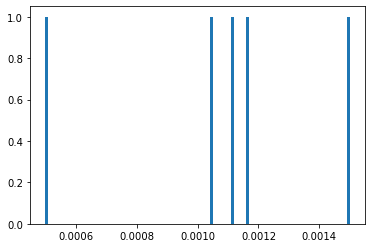

'c:\\Users\\bgy3\\OneDrive - PETROBRAS\\Documents\\PhD\\08.Simple-Fracture-Model-DARTS\\DA-DARTS-Naturally-Fractured-Reservoir-1'

In [166]:
#%%
#Generate the prior ensemble of scalar parameters
# build random values for fraction of aperture using normal distribution and fract_aper of the true model as mean as mean and 10% as std with seed=1
Em_frac_aper = np.clip(np.random.normal(1e-3, 0.5*(1e-3), Ne),0.0005,0.0015) #cliping to keep only positive numbvers for the frac apertures 

# data colums
columnsNameList = ['P1 : oil rate (m3/day)']

MScalarPrior = Em_frac_aper
#print MScalarPrioir histogram
plt.hist(MScalarPrior, bins=100)
plt.show()
#%%
curDir = os.getcwd()
srcDir =  f'{curDir}'
srcDir

In [167]:
#create a function to run ensemble simulations based on the prior ensemble
for i, mMScalar in enumerate(MScalarPrior):
   
   print(i)
   print(mMScalar)
   
   

0
0.001043184577783014
1
0.0011637818455206101
2
0.0015
3
0.0011152509687478418
4
0.0005


In [168]:
# %%
#Run ES-MDA
SDiag = np.sqrt(CeDiag)
SInvDiag = np.power(SDiag, -1)

INd = np.eye(Nd)

MGrid = [] #not considering grid parameters
MScalar = MScalarPrior

alphas = [4., 4., 4., 4.]
l = 0
for alpha in alphas:
    # 2. Forecast

    # Generates the perturbed observations 
    z = np.random.normal(size=(Nd,Ne))
    DPObs = dObs[:,np.newaxis] + math.sqrt(alpha) * CeDiag[:,np.newaxis] * z

    # Run the simulations g(M) 
    destDir = f'{curDir}\\simulations_deadoil\\it{l}'
    RunModels(destDir, MScalar)
    D = ReadModels(destDir, columnsNameList, Nd, Ne)
    if (l == 0):
        DPrior = D

    DobsD = DPObs - D

    # 4. Analysis
    # 4.1 Invert matrix C

    # Calculates DeltaD (12.5)
    meanMatrix = np.mean(D, axis=1)
    DeltaD = D - meanMatrix[:,np.newaxis]

    # Calculates CHat (12.10)
    CHat = SInvDiag[:,np.newaxis] * ( DeltaD @ DeltaD.T ) * SInvDiag[np.newaxis,:] + alpha * (Ne - 1) * INd

    # Calculates Gamma and X (12.18)
    U, SigmaDiag, Vt = np.linalg.svd(CHat)
    Nr = FindTruncationNumber(SigmaDiag, csi)

    GammaDiag = np.power(SigmaDiag[0:Nr], -1)
    X = SInvDiag[:,np.newaxis] * U[:,0:Nr]

    # Calculates M^a (12.21)
    X1 = GammaDiag[:,np.newaxis] * X.T
    X8 = DeltaD.T @ X
    X9 = X8 @ X1
    
    # subpart: for grid, use localization
    #MGrid = UpdateModelLocalized(MGrid, X9, Rmd, DobsD)

    # subpart: for scalars, don't use localization
    
    MScalar = UpdateModel(MScalar, X9, DobsD)
    MScalar[:] = np.clip(MScalar[:], 0.0005,0.0015)
    for i, mMScalar in enumerate(MScalar):
     print(i)
     print(mMScalar)
   
    l += 1
#%%
#MGridPost = MGrid
MScalarPost = MScalar
DPost = D



darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 5.0798985958099365 for model 0
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 5.486604690551758 for model 1
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 6.244538068771362 for model 2
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 5.039527416229248 for model 3
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 2.850001335144043 for model 4
0
0.0009972444505565513
1
0.0009937691397499497
2
0.0009952467539390726
3
0.0009942093990204968
4
0.0009947673509136006
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 5.049640655517578 for model 0
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 5.051403522491455 for model 1
darts-package built on 27/03/2022 15:20:27 by 

In [121]:
DobsD


array([[4803.47106948, 4804.2245882 , 3023.68655913, 1424.90056055,
        1531.03210056],
       [4796.11518216, 4794.79255669, 3019.38584457, 1426.82970762,
        1530.04061548],
       [4792.87616398, 4790.76877453, 3018.9574156 , 1424.92261467,
        1528.34409733],
       [4745.90435597, 4751.53075415, 2997.02530626, 1415.01670003,
        1516.66916094],
       [4531.00261358, 4528.50994519, 2889.30010778, 1364.36078492,
        1466.42228545],
       [2966.39023452, 2967.25848239, 2440.12167398, 1227.00188434,
        1319.52745498],
       [1185.07133672, 1184.85738375, 1056.16013893,  661.40606541,
         735.43881189],
       [ 879.22286065,  878.75901394,  742.53455907,  472.33386896,
         518.60448158],
       [ 999.81267741,  999.85562899,  874.90062995,  513.43683925,
         549.73452422],
       [1027.04001989, 1026.21014568,  909.64849429,  517.21172668,
         571.4851879 ],
       [1032.49870567, 1034.55858435,  914.47803584,  524.17607103,
         580

In [96]:
MScalar


array([0., 0., 0., 0., 0.])

In [104]:
ss = pd.read_pickle('c:\\Users\\bgy3\\OneDrive - PETROBRAS\\Documents\\PhD\\08.Simple-Fracture-Model-DARTS\\DA-DARTS-Naturally-Fractured-Reservoir-1\\simulations_deadoil\\it1\\data_model0.pkl') 
ss.head()




""


In [103]:
destDir

'c:\\Users\\bgy3\\OneDrive - PETROBRAS\\Documents\\PhD\\08.Simple-Fracture-Model-DARTS\\DA-DARTS-Naturally-Fractured-Reservoir-1\\simulations_deadoil\\it0'

Mean: prior=3.889e+03, post=7.984e-01
Std: prior=6.865e+03, post=2.114e+00


Text(0.5, 1.0, 'Histograms Objetive Functions')

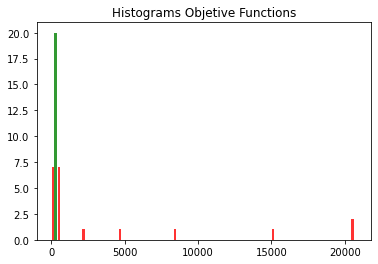

In [20]:
#%%
# Comparison of data mismatch objective function
# prior (l = 0)
CeInv = np.power(CeDiag, -1)
OPrior = calcDataMismatchObjectiveFunction(dObs[:,np.newaxis], DPrior, CeInv)
OPost = calcDataMismatchObjectiveFunction(dObs[:,np.newaxis], DPost, CeInv)

print(f'Mean: prior={np.mean(OPrior):.3e}, post={np.mean(OPost):.3e}')
print(f'Std: prior={np.std(OPrior, ddof=1):.3e}, post={np.std(OPost, ddof=1):.3e}')

fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((OPrior, OPost), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Objetive Functions')

Mean: prior=9.990e-04, post=9.998e-04
Std: prior=3.003e-04, post=3.498e-06


Text(0.5, 1.0, 'Histograms Fracture Apertures before and after history matching')

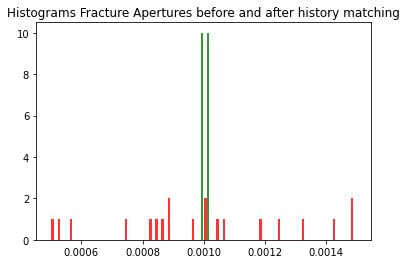

In [35]:
#Compare  the histograms of frac_aper prior and post

print(f'Mean: prior={np.mean(MScalarPrior):.3e}, post={np.mean(MScalarPost):.3e}')
print(f'Std: prior={np.std(MScalarPrior, ddof=1):.3e}, post={np.std(MScalarPost, ddof=1):.3e}')


fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((MScalarPrior, MScalarPost), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Fracture Apertures before and after history matching')



Text(0.5, 0.98, 'P1 : temperature (K)')

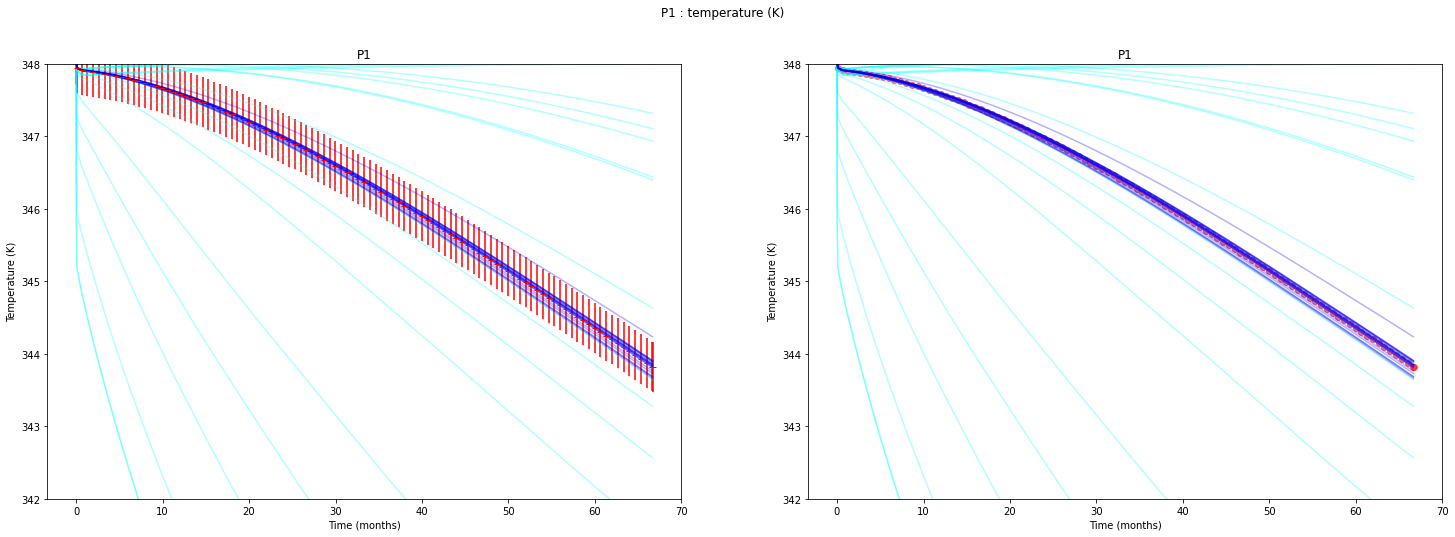

In [139]:
#%%
# Split the data into data array
wellDataPriorArray = np.split(DPrior, NWells)
wellDataPostArray = np.split(DPost, NWells)
wellDataObsArray = np.split(dObs, NWells)
wellDataObsErrorArray = np.split(CeDiag, NWells)

wellSubtitle = ['P1']
timeMonths = dTime/30.0


# get data and store in an array
prior = wellDataPriorArray # wellDataPriorArray[0:11:2]
post = wellDataPostArray # wellDataPostArray[0:11:2]
plotObsData = wellDataObsArray #wellDataObsArray[0:11:2]
errObsData = wellDataObsErrorArray #wellDataObsErrorArray[0:11:2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
axFlat = ax.flatten()

axFlat[0].set_facecolor('white')
axFlat[0].plot(timeMonths, prior[i], color='#00FFFF', alpha=0.3)
axFlat[0].plot(timeMonths, post[i], color='b', alpha=0.3)
axFlat[0].errorbar(timeMonths, plotObsData[i], yerr=errObsData[i], fmt='_ r', capthick=1, capsize=0.1)
#axFlat[0].plot(timeMonths, plotObsData[i],color='red', alpha=0.5)
axFlat[0].set_title(wellSubtitle[0])
axFlat[0].set_xlabel('Time (months)')
axFlat[0].set_ylabel('Temperature (K)')
axFlat[0].set_ylim([342, 348])


axFlat[1].plot(timeMonths, prior[i], color='#00FFFF', alpha=0.3)
axFlat[1].plot(timeMonths, post[i], color='b', alpha=0.3)
axFlat[1].scatter(timeMonths, plotObsData[0],color='red', alpha=0.5)
axFlat[1].set_title(wellSubtitle[0])
axFlat[1].set_xlabel('Time (months)')
axFlat[1].set_ylabel('Temperature (K)')
axFlat[1].set_ylim([342, 348])
fig.suptitle('P1 : temperature (K)')


In [1]:
!jupyter nbconvert --to html mainDA_explained.ipynb

[NbConvertApp] Converting notebook mainDA_explained.ipynb to html
[NbConvertApp] Writing 701465 bytes to mainDA_explained.html


Evaluating the Water Rate Results

In [155]:
vazao = ['P1 : water rate (m3/day)']
#Read the result of the posterior
D_qw = ReadModels(destDir, vazao, Nd, Ne)*(-1)
#Read the result of the prior
Prior = 20
D_qw_prior = ReadModels('simulations\it0', vazao, Nd, Prior)*(-1)

#Read the reference data 
obsData_qw= np.array(time_data['P1 : water rate (m3/day)'])
obsValues_qw = np.array(obsData_qw)*(-1)
dObs_qw = obsValues_qw.T.flatten()
CeDiag_qw =np.array(0.001*dObs_qw[:]) #diagonal of the covariance matrix of observed data %1 of the water rate



Text(0.5, 0.98, 'P1 : water rate (m3/day)')

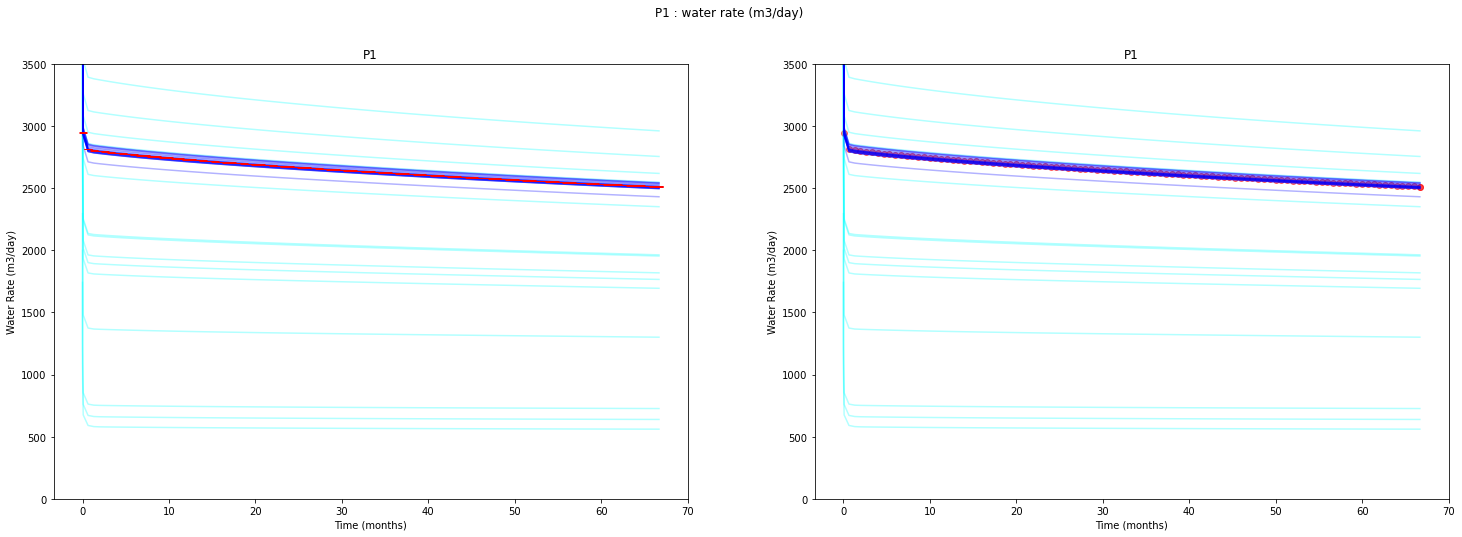

In [162]:
#%%
# Split the data into data array
wellDataPriorArray = np.split(D_qw_prior, NWells)
wellDataPostArray = np.split(D_qw, NWells)
wellDataObsArray = np.split(dObs_qw, NWells)
wellDataObsErrorArray = np.split(CeDiag_qw, NWells)

wellSubtitle = ['P1']
timeMonths = dTime/30.0


# get data and store in an array
prior = wellDataPriorArray # wellDataPriorArray[0:11:2]
post = wellDataPostArray # wellDataPostArray[0:11:2]
plotObsData = wellDataObsArray #wellDataObsArray[0:11:2]
errObsData = wellDataObsErrorArray #wellDataObsErrorArray[0:11:2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
axFlat = ax.flatten()

axFlat[0].set_facecolor('white')
axFlat[0].plot(timeMonths, prior[0], color='#00FFFF', alpha=0.3)
axFlat[0].plot(timeMonths, post[0], color='b', alpha=0.3)
axFlat[0].errorbar(timeMonths, plotObsData[0], yerr=errObsData[i], fmt='_ r', capthick=1, capsize=4)
#axFlat[0].plot(timeMonths, plotObsData[i],color='red', alpha=0.5)
axFlat[0].set_title(wellSubtitle[0])
axFlat[0].set_xlabel('Time (months)')
axFlat[0].set_ylabel('Water Rate (m3/day)')
axFlat[0].set_ylim([0, 3500])

axFlat[1].plot(timeMonths, prior[0], color='#00FFFF', alpha=0.3)
axFlat[1].plot(timeMonths, post[0], color='b', alpha=0.3)
axFlat[1].scatter(timeMonths, plotObsData[0],color='red', alpha=0.5)
axFlat[1].set_title(wellSubtitle[0])
axFlat[1].set_xlabel('Time (months)')
axFlat[1].set_ylabel('Water Rate (m3/day)')
axFlat[1].set_ylim([0, 3500])
fig.suptitle('P1 : water rate (m3/day)')



Mean: prior=8.654e+07, post=1.637e+04
Std: prior=1.268e+08, post=4.385e+04


Text(0.5, 1.0, 'Histograms Objetive Functions for water rate')

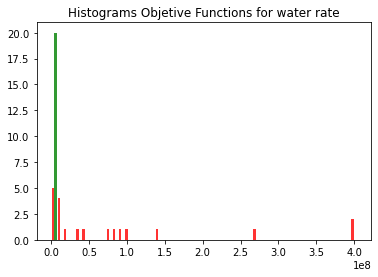

In [164]:
#%%
# Comparison of data mismatch objective function
CeInv_qw = np.power(CeDiag_qw, -1)
OPrior_qw = calcDataMismatchObjectiveFunction(dObs_qw[:,np.newaxis],D_qw_prior, CeInv_qw)
OPost_qw = calcDataMismatchObjectiveFunction(dObs_qw[:,np.newaxis],D_qw, CeInv_qw)
print(f'Mean: prior={np.mean(OPrior_qw):.3e}, post={np.mean(OPost_qw):.3e}')
print(f'Std: prior={np.std(OPrior_qw, ddof=1):.3e}, post={np.std(OPost_qw, ddof=1):.3e}')

fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((OPrior_qw, OPost_qw), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Objetive Functions for water rate')